In [1]:
import torch
import random
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4832442.50it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2220269.69it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9726431.24it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1522215.64it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


In [4]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2

      self.encoder = torch.nn.Sequential()
      self.decoder = torch.nn.Sequential()
      ##################
      ### Problem 2(b): finish the implementation for encoder and decoder
      ##################
      self.encoding_dims = [input_dim] + hidden_dims
      self.decoding_dims = [self.z_size] + self.encoding_dims[::-1]
      if decode_dim != -1:
          self.decoding_dims[-1] = decode_dim
      encoder_layers = []
      decoder_layers = []

      for i, dim in enumerate(self.encoding_dims[:-1]):
        encoder_layers.append(torch.nn.Linear(self.encoding_dims[i], self.encoding_dims[i+1]))
        encoder_layers.append(torch.nn.GELU())

      for i, dim in enumerate(self.decoding_dims[:-1]):
        decoder_layers.append(torch.nn.Linear(self.decoding_dims[i], self.decoding_dims[i+1]))
        decoder_layers.append(torch.nn.GELU())
      self.encoder = torch.nn.Sequential(*encoder_layers[:-1])
      self.decoder = torch.nn.Sequential(*decoder_layers[:-1])


  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      ##################
      ### Problem 2(c): finish the implementation for reparameterization
      ##################
      noise = torch.randn_like(logvar)
      return mean + torch.exp(logvar * 0.5) * noise

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)
      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = vae_test(test_tensor)


In [6]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    var = torch.exp(logvar)
    logp = -0.5 * ((sample - mean)**2/var +log2pi + logvar) 
    return torch.sum(logp, axis=raxis)

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz -logqz_x


In [7]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


In [8]:
##################
### Problem 3(c): Train VAE with ELBO loss
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

coeff = 1e-4

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 5e-3,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=coeff), optimizer_vae_sgvb, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=4, out_features=16, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=32, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=784, bias=True)
  )
)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.0225



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0180



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0169



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0163



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0158



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0156



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0154



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0152



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0150



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0149



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0148



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0148



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0148



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0147



Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0145



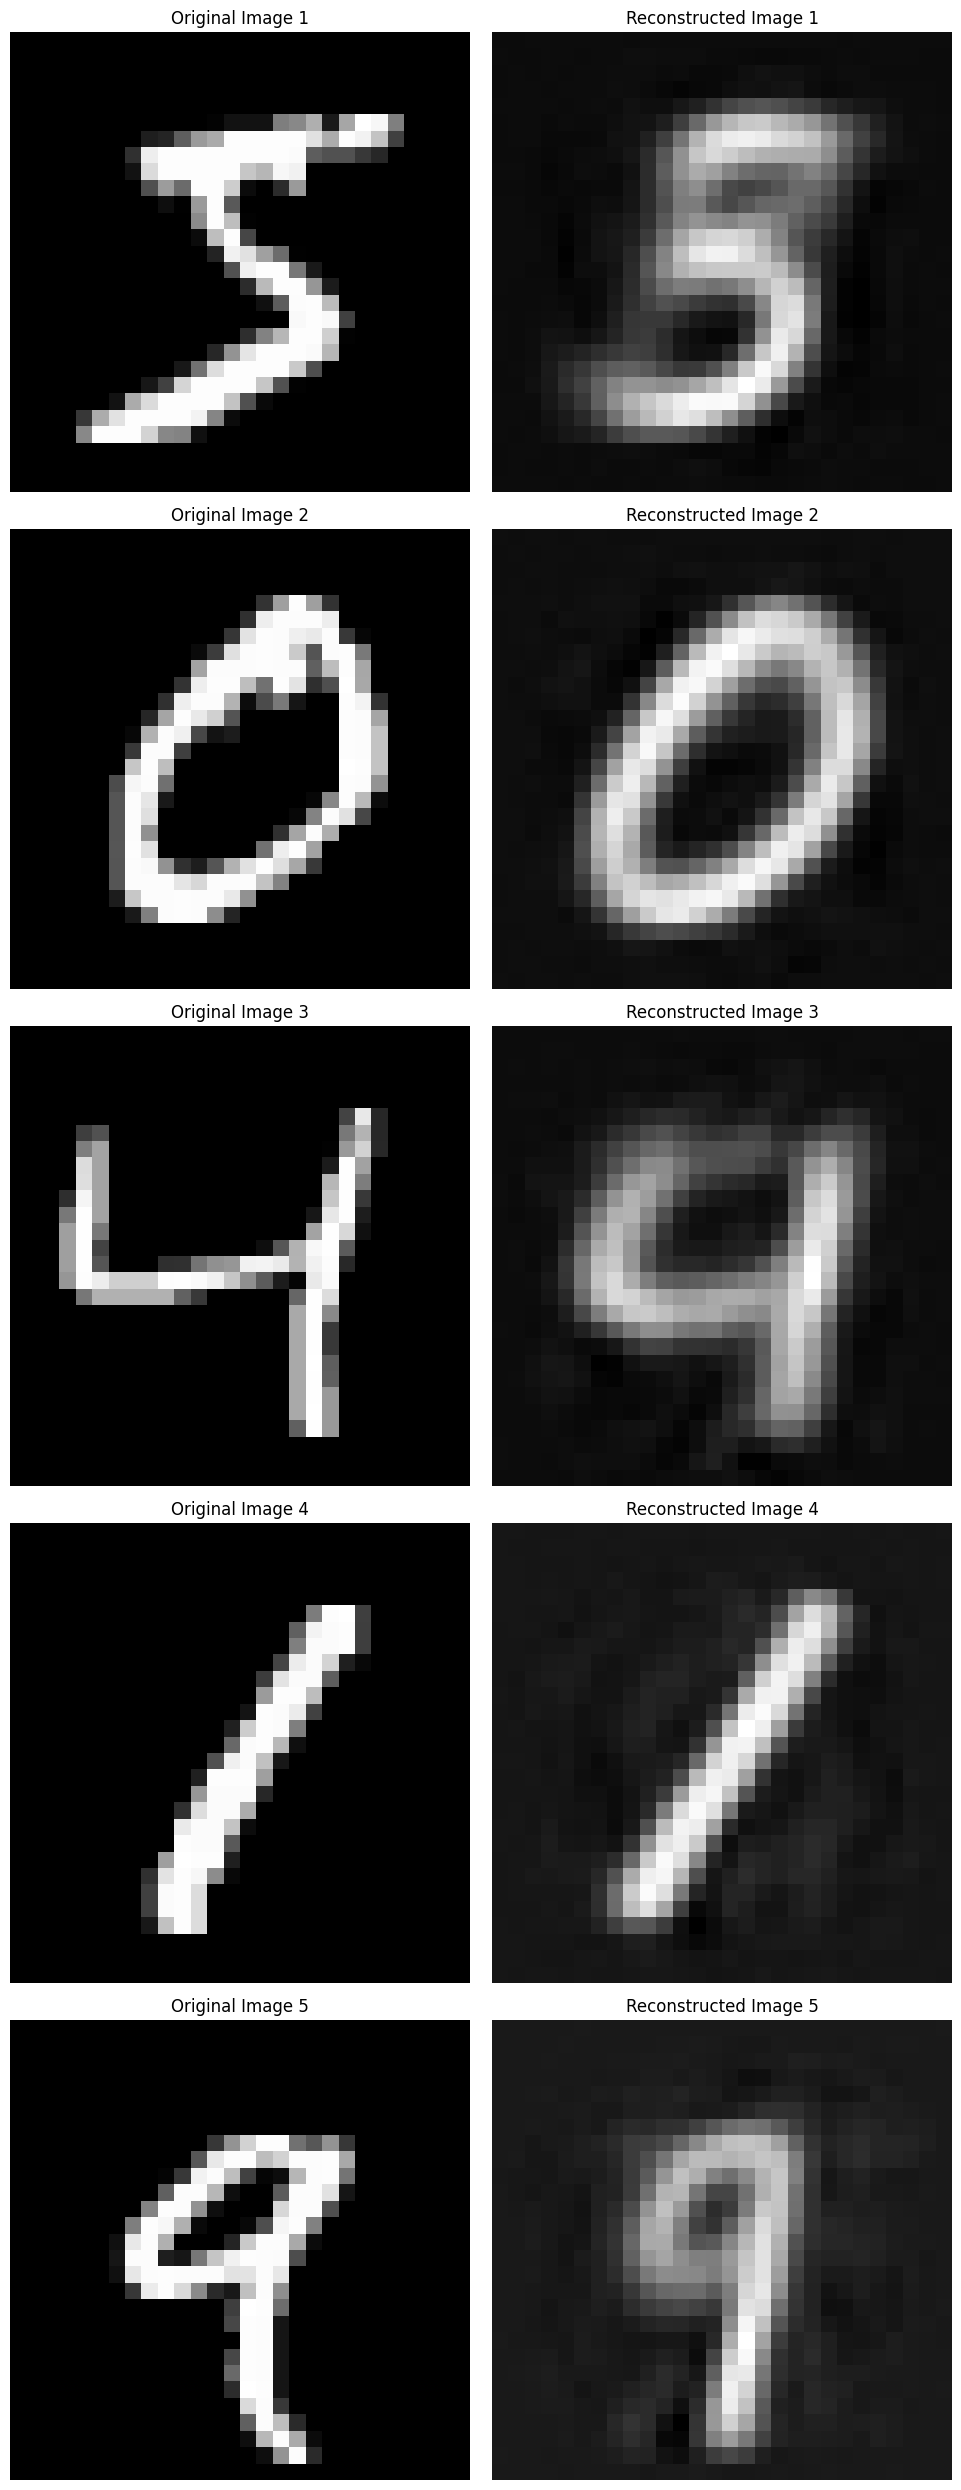

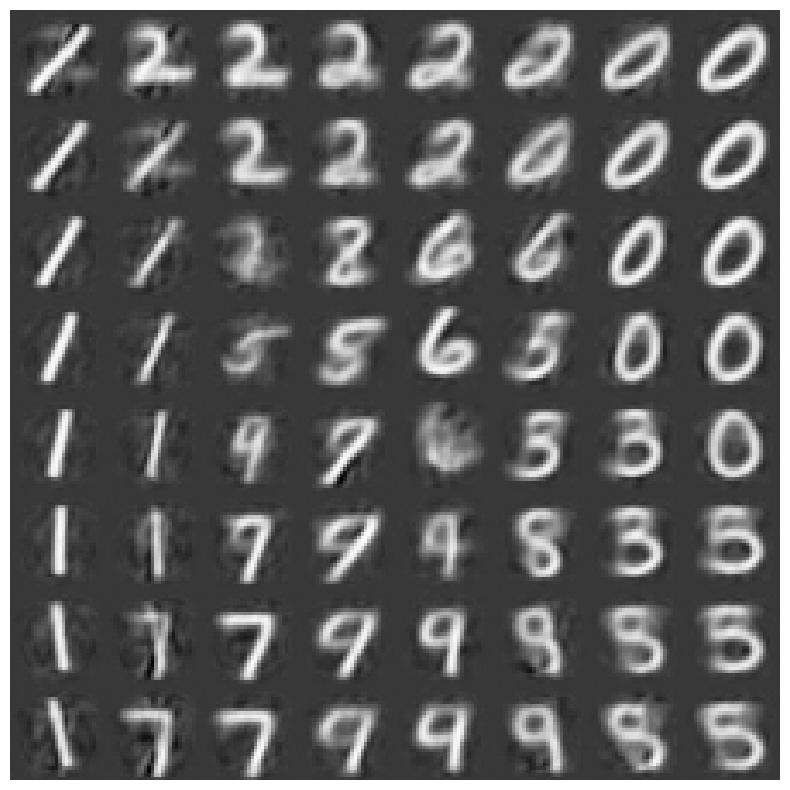

In [9]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


In [10]:
def calculate_class_latents(vae_model, dataloader, num_classes=10, device='cuda'):
    """
    Compute the average latent vector for each class using training data.
    
    Args:
        vae_model (VAE): The trained VAE model.
        dataloader (torch.utils.data.DataLoader): DataLoader containing the dataset.
        num_classes (int): Number of classes (default: 10 for MNIST).
        device (str): Device for computation.
    
    Returns:
        torch.Tensor: Averaged latent vectors for each class of shape (num_classes, latent_dim).
    """
    class_latents = {i: [] for i in range(num_classes)}  # Dictionary to store latents per class
    
    vae_model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Calculating Class Latents'):
            images = images.to(device)
            labels = labels.to(device)
            
            # Flatten the images for the encoder
            images_flat = images.view(images.size(0), -1)
            
            # Encode to latent space
            mean, log_var = vae_model.encode(images_flat)
            latent = mean  # Use the mean as the latent representation
            
            # Store latents by class
            for i in range(images.size(0)):
                class_latents[labels[i].item()].append(latent[i].cpu())
    
    # Compute the average latent vector for each class
    avg_latents = torch.zeros((num_classes, vae_model.z_size))
    for class_label, latents in class_latents.items():
        avg_latents[class_label] = torch.stack(latents).mean(dim=0)
    
    return avg_latents.to(device)


def classify_with_vae_avg(vae_model, input_image, avg_latents, num_classes=10):
    """
    Classify an input image using a trained VAE and average class latent vectors.
    
    Args:
        vae_model (VAE): The trained VAE model.
        input_image (torch.Tensor): The input image tensor of shape (1, 28, 28).
        avg_latents (torch.Tensor): Averaged latent vectors for each class.
        num_classes (int): Number of classes (default: 10 for MNIST).
    
    Returns:
        int: The predicted class label.
    """
    # Ensure the input image is in the correct format
    if input_image.ndim == 3:
        input_image = input_image.unsqueeze(0)  # Add batch dimension

    # Flatten the input image for L2 comparison
    input_image_flat = input_image.view(input_image.size(0), -1)

    closest_label = -1
    min_distance = float('inf')

    for class_label in range(num_classes):
        # Decode the average latent vector for the class
        generated_image = vae_model.decode(avg_latents[class_label].unsqueeze(0))
        generated_image_flat = generated_image.view(generated_image.size(0), -1)  # Flatten generated image

        # Compute L2 distance
        l2_distance = torch.norm(input_image_flat - generated_image_flat, p=2)

        # Update closest label if distance is smaller
        if l2_distance < min_distance:
            min_distance = l2_distance
            closest_label = class_label

    return closest_label


def classification_eval_avg(dataloader, model, avg_latents, num_classes=10, epochs=1):
    """
    Evaluate the classification performance of the VAE-based classifier using averaged latents.
    
    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        model (torch.nn.Module): Trained VAE model.
        avg_latents (torch.Tensor): Averaged latent vectors for each class.
        num_classes (int): Number of classes.
        epochs (int): Number of evaluation epochs.
    
    Returns:
        list: Average accuracy per epoch.
    """
    accuracies = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        correct_predictions = 0
        total_predictions = 0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.to(device)
            labels = labels.to(device)

            # Predict labels for the batch
            pred_labels = []
            for image in images:
                pred_label = classify_with_vae_avg(model, image, avg_latents, num_classes=num_classes)
                pred_labels.append(pred_label)

            # Convert to tensor
            pred_labels = torch.tensor(pred_labels, device=device)

            # Calculate accuracy for the batch
            correct_predictions += (pred_labels == labels).sum().item()
            total_predictions += batch_size

        # Calculate average accuracy for the epoch
        epoch_accuracy = correct_predictions / total_predictions
        accuracies.append(epoch_accuracy)

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Acc: {epoch_accuracy:.4f}\n')

    return accuracies


In [11]:
avg_latents = calculate_class_latents(vae_model=vae_sgvb, 
                                      dataloader=MNIST_loader, 
                                      num_classes=10, 
                                      device=device)

Calculating Class Latents:   0%|          | 0/235 [00:00<?, ?it/s]

In [12]:
# Assuming MNIST_loader is your DataLoader and vae_model is your trained VAE instance
vae_sgvb.eval()  # Set the model to evaluation mode

# Evaluate classification performance
accuracies = classification_eval_avg(MNIST_loader, vae_sgvb, avg_latents, num_classes=10, epochs=1)
print(f'Final Accuracy: {accuracies[-1]:.4f}')


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

----
Epoch [1/1], Average Acc: 0.5548

Final Accuracy: 0.5548


In [20]:
def split_data(train_dataset):
    """
    Splits the dataset by class labels into a dictionary of lists.
    """
    data = {x: [] for x in range(10)}  # Initialize dictionary for 10 classes
    for img, label in train_dataset:
        data[label].append((img, label))  # Append each sample to the corresponding label key
    return data

def create_biased_dataset(data, probs):
    """
    Creates a biased dataset according to the given probabilities.

    Parameters:
        data: Dictionary with label keys and corresponding (image, label) lists
        probs: List of probabilities for each class
    
    Returns:
        A biased list of (image, label) samples.
    """
    max_p = max(probs)  # Find the maximum probability
    max_x = np.argmax(probs)  # Find the class with the maximum probability
    max_n = int(0.9 * len(data[max_x]))  # Determine the maximum number of samples
    res = []

    for x, samples in data.items():
        n = int(max_n * probs[x] / max_p)  # Scale the number of samples for each class
        res += random.sample(samples, n)  # Randomly sample 'n' items from the current class

    random.shuffle(res)  # Shuffle the entire biased dataset
    return res

data_class = split_data(MNIST_dataset)

In [21]:
class BiasedVAEClassifier:
    def __init__(self, vae_model, n_classes=10, device='cuda'):
        """
        Biased VAE Classifier that adjusts class thresholds based on biases.
        
        Args:
            vae_model: Trained VAE model.
            n_classes (int): Number of classes (default: 10 for MNIST).
            device (str): Device for computation (default: 'cuda').
        """
        self.vae_model = vae_model
        self.n_classes = n_classes
        self.counts = [0 for _ in range(n_classes)]
        self.pys = [1 / n_classes for _ in range(n_classes)]
        self.device = device

    def predict_proba(self, X, avg_latents):
        """
        Predict class probabilities for the input using the VAE model.

        Args:
            X (torch.Tensor): Input images.
            avg_latents (torch.Tensor): Averaged latent representations for each class.
        
        Returns:
            torch.Tensor: Predicted probabilities for each class.
        """
        probabilities = []
        for xi in X:
            errs = []
            for class_idx in range(self.n_classes):
                latent = avg_latents[class_idx].to(self.device)  # Use avg_latents passed explicitly
                generated_image = self.vae_model.decode(latent.unsqueeze(0))
                err = torch.norm(xi.view(-1) - generated_image.view(-1), p=2)
                errs.append(err.item())

            # Compute probabilities using exp(-Err^2)
            errs = torch.tensor(errs, device=self.device)
            exp_neg_squared = torch.exp(-errs**2)
            probs = exp_neg_squared / exp_neg_squared.sum()  # Normalize probabilities
            probabilities.append(probs)

        return torch.stack(probabilities)

    def predict(self, X, avg_latents):
        """
        Predict class labels for the input.

        Args:
            X (torch.Tensor): Input images.
            avg_latents (torch.Tensor): Averaged latent representations for each class.
        
        Returns:
            torch.Tensor: Predicted class labels.
        """
        proba = self.predict_proba(X, avg_latents)
        return torch.argmax(proba * torch.tensor(self.pys, device=self.device), dim=1)

    def predict_biased_online(self, X, y, avg_latents):
        """
        Online prediction with dynamic threshold adjustments.

        Args:
            X (torch.Tensor): Input images.
            y (torch.Tensor): True labels.
            avg_latents (torch.Tensor): Averaged latent representations for each class.
            alpha (float): Learning rate for threshold adjustment.
        
        Returns:
            tuple: Predicted labels, threshold history, and probability history.
        """
        res = []

        for xi, yi in zip(X, y):
            proba = self.predict_proba(xi.unsqueeze(0), avg_latents)
            predicted_class = torch.argmax(proba * torch.tensor(self.pys, device=self.device)).item()
            res.append(predicted_class)

            if predicted_class == yi.item():
                self.counts[yi.item()] += 1
            else:
                for j in range(self.n_classes):
                    if j == yi.item():
                        continue
                    self.counts[j] += 1/9
            
            self.pys = [x / sum(self.counts) for x in self.counts]

        return torch.tensor(res, device=self.device)

In [22]:
def biased_eval(dataloader, model, avg_latents, method='online'):
    """
    Evaluate the classification performance of the VAE-based classifier using averaged latents.
    
    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        model (torch.nn.Module): Trained VAE model.
        avg_latents (torch.Tensor): Averaged latent vectors for each class.
    
    Returns:
        acc: classification accuracy
    """
    accuracies = []

    correct_predictions = 0
    total_predictions = 0
    batch_progress = tqdm(dataloader, desc='Batches', leave=False)

    for iter, (images, labels) in enumerate(batch_progress):
        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)

        # Predict labels for the batch
        pred_labels = []
        if method == 'online':
            pred_labels = model.predict_biased_online(images, labels, avg_latents)
        else:
            pred_labels = model.predict(images, avg_latents)
        # for image in images:
        #     pred_label = model.predict_biased_online(image, )
        #     pred_labels.append(pred_label)

        # Convert to tensor
        pred_labels = torch.tensor(pred_labels, device=device)

        # Calculate accuracy for the batch
        correct_predictions += (pred_labels == labels).sum().item()
        total_predictions += batch_size

        # Calculate average accuracy for the epoch
        epoch_accuracy = correct_predictions / total_predictions
        accuracies.append(epoch_accuracy)

    return correct_predictions / total_predictions

In [26]:
class BiasedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    
biased_data = create_biased_dataset(data_class, [0.5] + [0.5/9] * 9)

biased_dataset = BiasedDataset(biased_data)
biased_loader = DataLoader(biased_dataset, batch_size=256, shuffle=True)

vae_bias = BiasedVAEClassifier(vae_sgvb, 10, 'cpu')

biased_acc = biased_eval(biased_loader, vae_bias, avg_latents, method='original')
print(f"Accuracy on Biased Dataset (Original): {biased_acc:.4f}")

biased_acc = biased_eval(biased_loader, vae_bias, avg_latents, method='online')
print(f"Accuracy on Biased Dataset (Online): {biased_acc:.4f}")

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\ronsh\AppData\Local\Temp\ipykernel_30108\1715673431.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = torch.tensor(pred_labels, device=device)


Accuracy on Biased Dataset (Original): 0.6177


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Accuracy on Biased Dataset (Online): 0.6263


# First experiment

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [27]:
def prepare_biased_loaders(dataset, bias_ratios, batch_size=256, shuffle=True, num_workers=0):
    """
    Prepares biased data loaders for different class bias ratios.
    
    Args:
        dataset (torch.utils.data.Dataset): The original dataset.
        bias_ratios (dict): A dictionary where keys are bias ratios (e.g., 0.1, 0.2) 
                            and values are lists specifying class sampling ratios.
        batch_size (int): Batch size for the DataLoader.
        shuffle (bool): Whether to shuffle the DataLoader.
        num_workers (int): Number of workers for the DataLoader.
    
    Returns:
        dict: A dictionary where keys are bias ratios and values are DataLoader instances.
    """
    # Split dataset by class
    data_by_class = split_data(dataset)
    
    # Create biased datasets for each ratio
    biased_loaders = {}
    for ratio, class_ratios in bias_ratios.items():
        biased_data = create_biased_dataset(data_by_class, class_ratios)
        biased_dataset = BiasedDataset(biased_data)
        biased_loaders[ratio] = DataLoader(biased_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return biased_loaders

In [29]:
# Define the desired class sampling ratios for different bias settings
bias_ratios = {
    0.1: [0.1] + [0.9 / 9] * 9,  # Class 0 is overrepresented
    0.2: [0.2] + [0.8 / 9] * 9,
    0.3: [0.3] + [0.7 / 9] * 9,
    0.4: [0.4] + [0.6 / 9] * 9,
    0.5: [0.5] + [0.5 / 9] * 9,
    0.6: [0.6] + [0.4 / 9] * 9,
    0.7: [0.7] + [0.3 / 9] * 9,
    0.8: [0.8] + [0.2 / 9] * 9,
    0.9: [0.9] + [0.1 / 9] * 9,
}

biased_loaders = prepare_biased_loaders(
    dataset=MNIST_dataset,  # Replace with your dataset
    bias_ratios=bias_ratios,
    batch_size=256,
    shuffle=True,
    num_workers=4
)

In [32]:
biased_loader_01 = biased_loaders[0.1]
biased_loader_02 = biased_loaders[0.2]
biased_loader_03 = biased_loaders[0.3]
biased_loader_04 = biased_loaders[0.4]
biased_loader_05 = biased_loaders[0.5]
biased_loader_06 = biased_loaders[0.6]
biased_loader_07 = biased_loaders[0.7]
biased_loader_08 = biased_loaders[0.8]
biased_loader_09 = biased_loaders[0.9]

In [37]:
def evaluate_biased_vae_classifier(test_datasets, model, avg_latents, og_model):
    """
    Evaluate the BiasedVAEClassifier with different thresholds and compare 
    its online performance to the non-online version.

    Args:
        test_datasets (dict): Dictionary of test datasets with their bias ratios as keys.
        model (BiasedVAEClassifier): The BiasedVAEClassifier instance.
        avg_latents (torch.Tensor): Averaged latent vectors for each class.
        og_model (BiasedVAEClassifier): Non-online version of the model for comparison.

    Returns:
        dict: Threshold histories, probability histories, and performance metrics.
    """
    # Prepare the test data
    accuracies = []
    precisions = []
    recalls = []
    ratios = []
    og_accuracies = []
    og_precisions = []
    og_recalls = []

    threshold_histories = {}
    prob_histories = {}

    for ratio, test_loader in test_datasets.items():
        print(f"Test Bias Ratio: {ratio}")

        # Evaluate online method
        X_test, y_test = [], []
        for x, y in test_loader:
            X_test.append(x)
            y_test.append(y)
        X_test = torch.stack(X_test).to(model.device)
        y_test = torch.tensor(y_test).to(model.device)

        predictions, threshold_history, prob_history = model.predict_biased_online(X_test, y_test, avg_latents)
        threshold_histories[ratio] = threshold_history
        prob_histories[ratio] = prob_history

        # Evaluate the non-online (original) method
        og_predictions = og_model.predict(X_test, avg_latents)

        # Calculate metrics
        accuracies.append((predictions == y_test).sum().item() / len(y_test))
        precisions.append(precision_score(y_test.cpu(), predictions.cpu(), average="macro"))
        recalls.append(recall_score(y_test.cpu(), predictions.cpu(), average="macro"))

        og_accuracies.append((og_predictions == y_test).sum().item() / len(y_test))
        og_precisions.append(precision_score(y_test.cpu(), og_predictions.cpu(), average="macro"))
        og_recalls.append(recall_score(y_test.cpu(), og_predictions.cpu(), average="macro"))

        ratios.append(ratio)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_accuracies, label="Original Accuracy", color="blue")
    plt.plot(ratios, accuracies, label="Online Accuracy", color="red")
    plt.xlabel("Bias Ratio")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison for Different Thresholds")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_precisions, label="Original Precision", color="blue")
    plt.plot(ratios, precisions, label="Online Precision", color="red")
    plt.xlabel("Bias Ratio")
    plt.ylabel("Precision")
    plt.title("Precision Comparison for Different Thresholds")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_recalls, label="Original Recall", color="blue")
    plt.plot(ratios, recalls, label="Online Recall", color="red")
    plt.xlabel("Bias Ratio")
    plt.ylabel("Recall")
    plt.title("Recall Comparison for Different Thresholds")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "threshold_histories": threshold_histories,
        "prob_histories": prob_histories,
        "accuracies": accuracies,
        "precisions": precisions,
        "recalls": recalls,
        "og_accuracies": og_accuracies,
        "og_precisions": og_precisions,
        "og_recalls": og_recalls,
    }


In [ ]:
# Test datasets with different bias ratios
test_datasets = {
    0.1: biased_loader_01,
    0.2: biased_loader_02,
    0.3: biased_loader_03,
    0.4: biased_loader_04,
    0.5: biased_loader_05,
    0.6: biased_loader_06,
    0.7: biased_loader_07,
    0.8: biased_loader_08,
    0.9: biased_loader_09,
}

# Evaluate the models
results = evaluate_biased_vae_classifier(test_datasets, vae_bias, avg_latents, vae_bias)

# Access results
print("Accuracies (Online):", results["accuracies"])
print("Accuracies (Original):", results["og_accuracies"])


Test Bias Ratio: 0.1
